In this notebook, we go through feature importance analysis. Feature importance analysis is useful tool to find and validate statistical edges. Although p-value has been widely used to validate statistical patterns, it has some caveats:

1. Relying on the strong assumption
2. In the existence of highly multi collinear model, p-value cannot be robust
3. Estimating parameter value probability rather than probability of the null hypothesis in general
4. Significance at in-sample

The first caveat implies that the model assumes linear model with Gaussian noise, which is not always the case in real world problems. The second caveat states that traditional regression model cannot discriminate among redundant variables, leading to substitution effects between related p-values. Third caveat comes from the fact that p-value estimate probability of empirically estimated parameter being generated subjected to null hypothesis. Thus, they do not provide the probability of null hypothesis being true. The fourth caveat is that p-value estimates significance at in-sample. Multiple testing inflates estimated p-values and leads to p-hacking.

Feature importance is alternative way and solve these caveats.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

We use an artificially generated classification problem. Data has some informative, redundant, and noise features.

In [2]:
from finance_ml.experiments import get_classification_data

X,y = get_classification_data(40, 5, 30, 10000, sigma=0.1)
print(X.shape)
print(X.head())
print(f"columns={X.columns.tolist()}")

(10000, 40)
        I_0       I_1       I_2       I_3       I_4       N_0       N_1  \
0  2.105359  2.861661  0.104159  0.686149  1.369429 -0.868903 -1.297125   
1 -0.330754  1.464379 -1.405119  0.396713 -1.722305  0.471952 -1.443687   
2 -0.461334 -0.160432 -2.169501 -0.137535  0.398229 -0.278979 -1.860566   
3 -1.573667  3.110105  0.073939  1.232501  1.069429  0.700720 -1.097145   
4  0.528677  1.538982 -1.603758  2.056413  0.777722 -0.644594 -0.304476   

        N_2       N_3       N_4  ...      R_20      R_21      R_22      R_23  \
0 -0.160205 -0.481024  0.841338  ...  2.349950  0.166769  0.380488  2.693087   
1 -0.433773  0.123114 -0.102970  ... -0.387650 -1.457474 -1.381808  1.461375   
2  0.909540 -0.396742  2.455228  ... -0.415860 -2.050442 -2.266655 -0.104174   
3  0.157145 -1.699373  1.167458  ... -1.524246  0.169084  0.130410  3.068232   
4  0.682256 -0.644368  0.280994  ...  0.517340 -1.628636 -1.762587  1.535581   

       R_24      R_25      R_26      R_27      R_28     

/home/tom/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Each feature is named as the following name convention:
1. I_\*: informative feature
2. R_\*: redundant feature. The information is shared with some I_\*
3. N_\*: noise feature. No predictive power is contained

# Mean-Decrease Impurity (MDI)

MDI is feature importance is sub-products of decision tree learning process.
At each node t splitting with feature f, a tree maximize impurity gain

$$ \Delta g[t, f] = i[t] - (\frac{N^0}{N} i[t^0] +\frac{N^1}{N} i[t^1])$$

where $N^0$ and $N^1$ are the number of samples of left and right node. $i[t^0]$ and $i[t^1]$ are impurity of left and right node.

This impurities are aggregated across nodes with weighted average. The value is bounded at [0, 1] and all added up to 1. The non-important value is expected to be around 1/F where F features exist.

         mean       std
I_0  0.020411  0.000395
I_1  0.057504  0.001633
I_2  0.024392  0.000564
I_3  0.017356  0.000187
I_4  0.030132  0.000831
1/F = 0.025


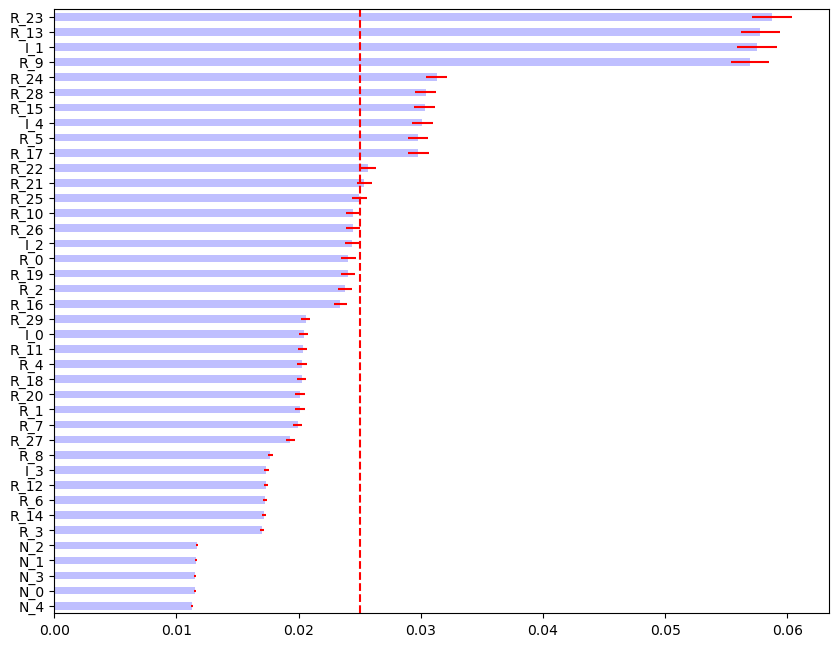

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import multiprocessing as mp

from finance_ml.importance import feat_imp_MDI


clf = DecisionTreeClassifier(criterion="entropy", max_features=1, class_weight="balanced", min_weight_fraction_leaf=0)
clf = BaggingClassifier(base_estimator=clf, n_estimators=1000, max_features=1.,
                        max_samples=1., oob_score=False, n_jobs=mp.cpu_count())
clf.fit(X, y);
imp = feat_imp_MDI(clf, X.columns)
print(imp.head())
imp.sort_values('mean', inplace=True)
plt.figure(figsize=(10, imp.shape[0] / 5));
F = X.shape[1]
print(f"1/F = {1./F}")
plt.axvline(x=1./F, linestyle='dashed', color='r');
imp['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=imp['std'], error_kw={'ecolor': 'r'});

MDI does a good job. Non-noisy features are ranked higher than noise ones. Due to substitution effects, some non-noisy features appear to be much more important than the others. This comes from the fact that some features share the information of other features and they are not necessary to be used for prediction.

MDI solves three out of four caveats, 1-3. First, trees do not assume any specific algebraic formula. Second, ensemble of tress reduce variance of the model. Lastly, MDI estimates usefulness of the feature in general. MDI is , however, still estimated at in-sample.

# Mean-Decrease Accuracy (MDA)

To combat caveat 4, we introduce MDA, which estimates importance using cross validation. For each round, one of the features are shuffled one by one and see the difference from the original performance. This importance is not bounded. 

         mean       std
I_0  0.019023  0.010687
I_1  0.056074  0.016831
I_2  0.026049  0.010414
I_3  0.020234  0.005002
I_4  0.018102  0.016156


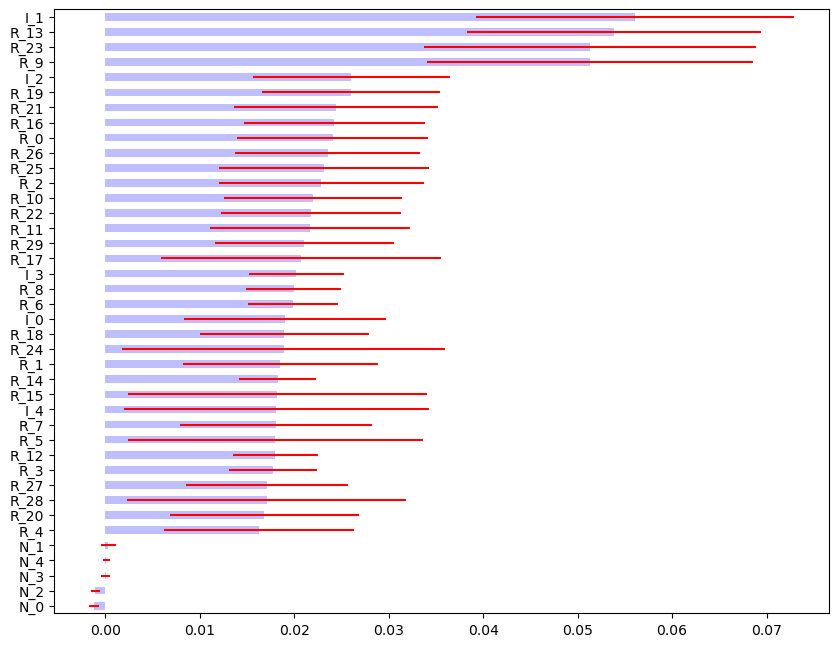

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import multiprocessing as mp

from finance_ml.importance import feat_imp_MDA

clf = DecisionTreeClassifier(criterion="entropy", max_features=1, class_weight="balanced", min_weight_fraction_leaf=0)
clf = BaggingClassifier(base_estimator=clf, n_estimators=1000, max_features=1.,
                        max_samples=1., oob_score=False, n_jobs=mp.cpu_count())
imp = feat_imp_MDA(clf, X, y, n_splits=5)
print(imp.head())
imp.sort_values('mean', inplace=True)
plt.figure(figsize=(10, imp.shape[0] / 5))
imp['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=imp['std'], error_kw={'ecolor': 'r'});

This method can use any scores in general. One thing you have to care about is substitution effects. In the extreme case, you have two identical features. One of them is shuffled, the accuracy may not change. Thus, feature importance would be close to zero.

# Substitution Effects

When more than one features share the same predictive information, substitution effects can bias the results of features importance. In the case of MDI, the importance would be halved.

In order to deal with this, we have two methods:
1. Orthogonalization: Generate PCA components features and estimate importances on them
2. Clustering Features: Cluster features and estimate importance of clusters

The method 1, may reduce the substitution effects, but it has three caveats:
1. non linear relation redundant features still cause substitution effects
2. May not have intuitive explanation
3. Defined by eigen vectors, which may not necessary maximize the output


Let's look at clustering feature importance.

For clustering method, it involves the two steps:
1. Features Clustering
2. Clustered Importance

For step1, you can utilize ONC algorithm(`finance_ml/clustering.py`). In this step, you can check the quality of clustering based on silhouette scores. If the scores is not good, one feature may contain information across multiple clusters. you can use the following algorithms:

$$X_{n, i} = \alpha_i + \sum_{j \in \cup_{l < k} D_l} \beta_{i, j} X_{n, j} + \epsilon_{n, i} \forall i \in D_k$$

For each cluster, you regress on the the other cluster. Then you can use residual instead.

In the step2, we estimate importance of each cluster rather than individual features.

{0: ['I_3', 'R_3', 'R_6', 'R_8', 'R_12', 'R_14'], 1: ['I_2', 'R_0', 'R_2', 'R_10', 'R_16', 'R_19', 'R_21', 'R_22', 'R_25', 'R_26'], 2: ['I_0', 'R_1', 'R_4', 'R_7', 'R_11', 'R_18', 'R_20', 'R_27', 'R_29'], 3: ['I_4', 'R_5', 'R_15', 'R_17', 'R_24', 'R_28'], 4: ['I_1', 'R_9', 'R_13', 'R_23'], 5: ['N_0', 'N_1', 'N_2', 'N_3', 'N_4']}


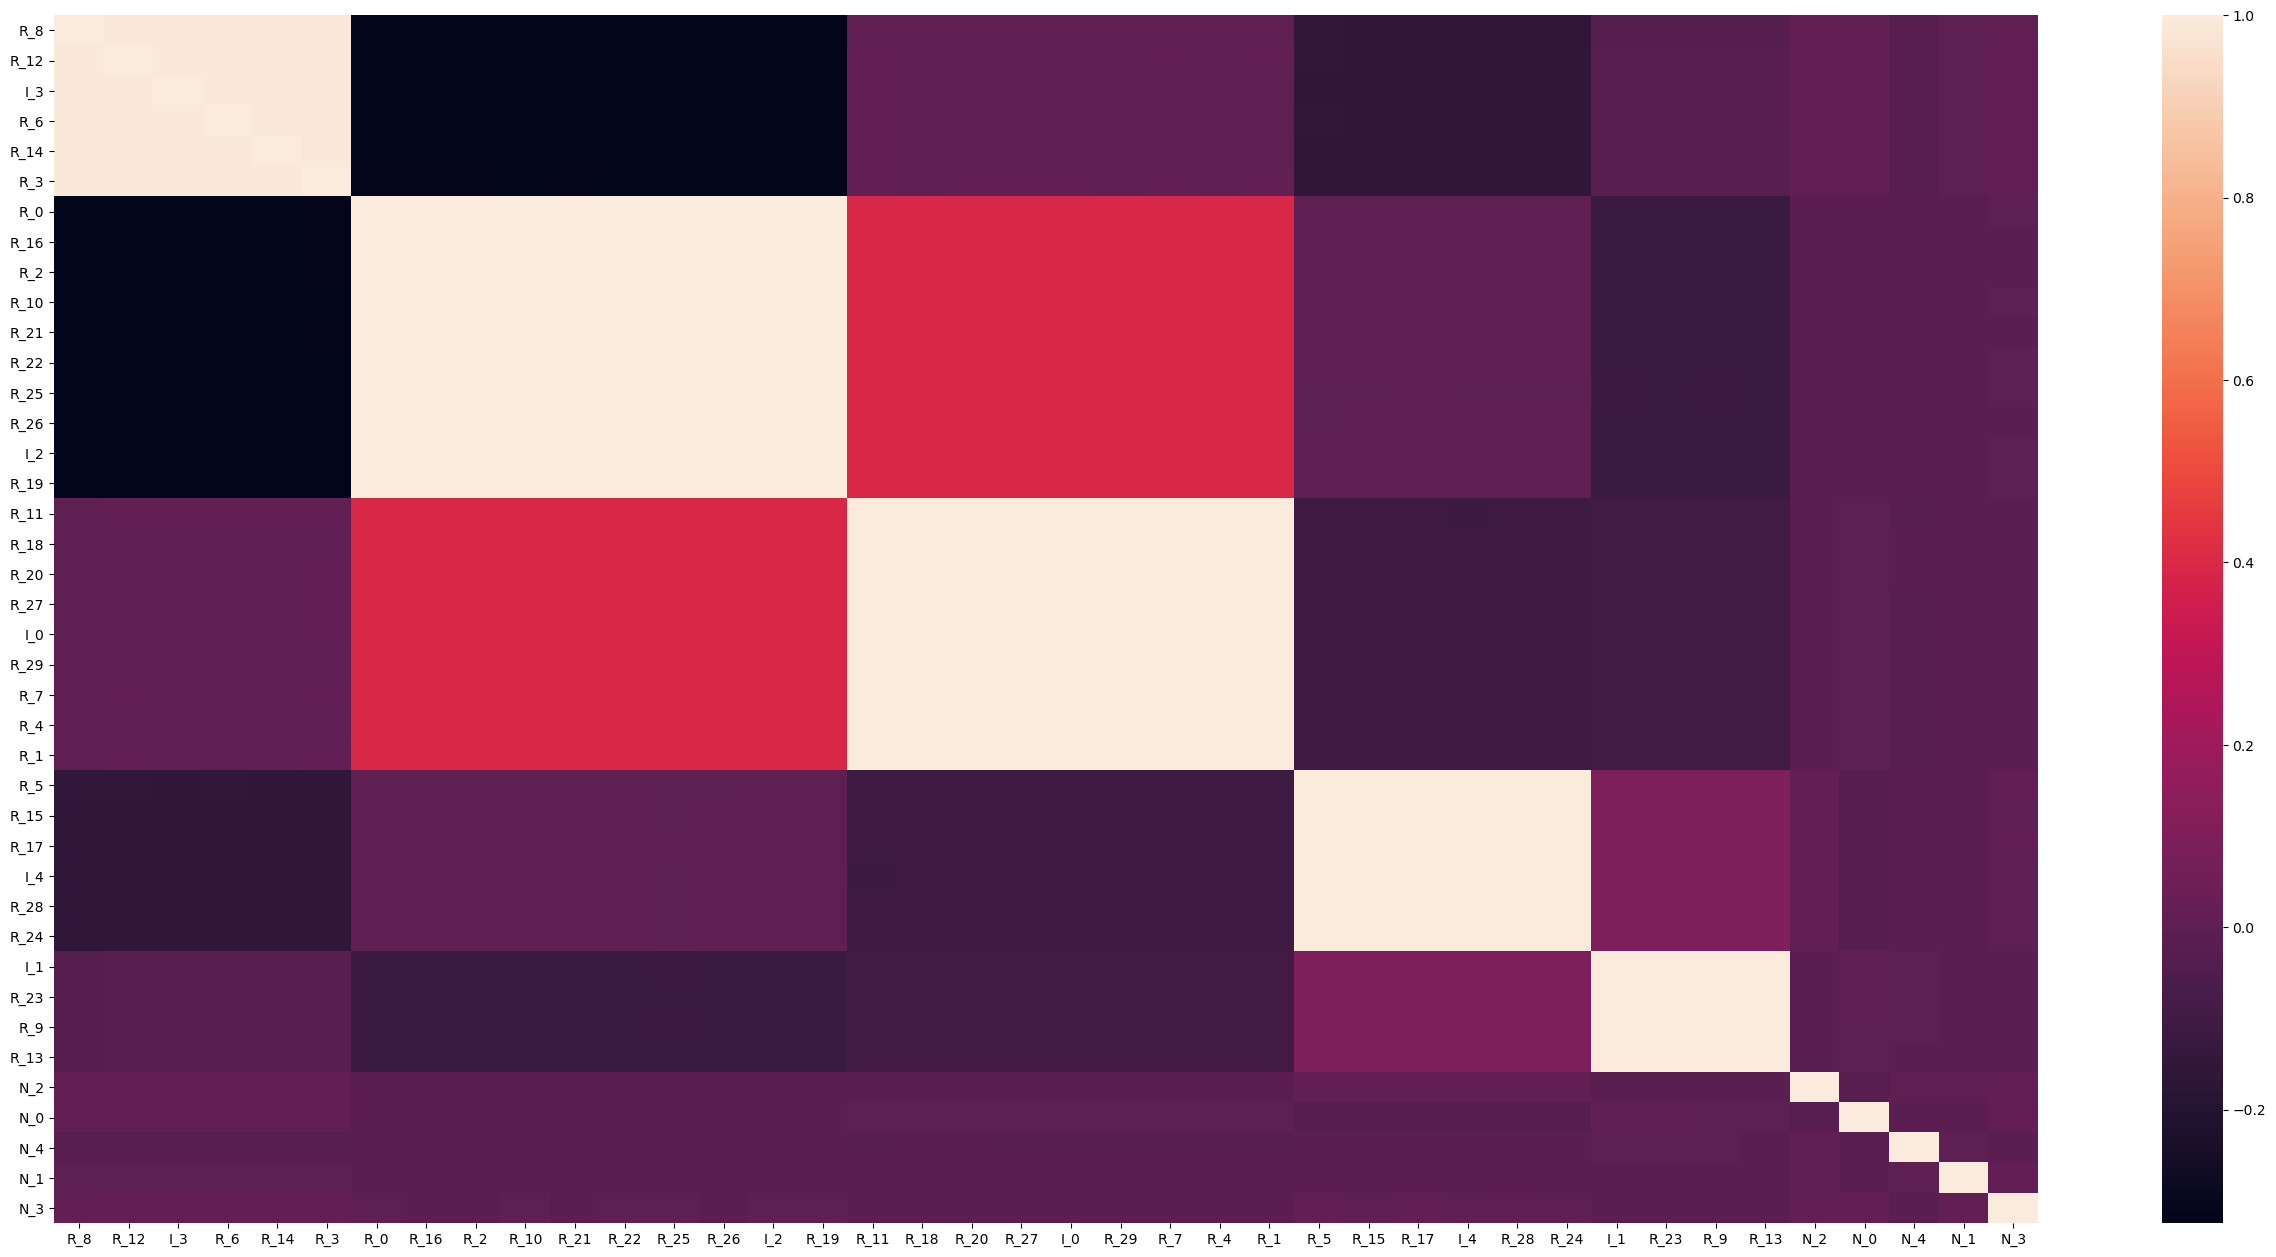

In [3]:
from finance_ml.clustering import cluster_kmeans_base
import warnings
warnings.simplefilter('ignore')


corr0, clstrs, silh = cluster_kmeans_base(X.corr(), max_num_clusters=10, n_init=20)
print(clstrs)
sns.heatmap(corr0);

In this clustering, one of the cluster contains noise features.

         mean          std
C_0  0.103742  0.000405613
C_1  0.244624  0.000720762
C_2  0.180836  0.000634086
C_3  0.181259  0.000846484
C_4  0.231991   0.00131483


<AxesSubplot:>

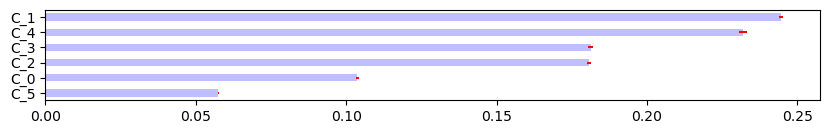

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import multiprocessing as mp

from finance_ml.importance import feat_imp_MDI_clustered


clf = DecisionTreeClassifier(criterion="entropy", max_features=1, class_weight="balanced", min_weight_fraction_leaf=0)
clf = BaggingClassifier(base_estimator=clf, n_estimators=1000, max_features=1.,
                        max_samples=1., oob_score=False, n_jobs=mp.cpu_count())

clf = clf.fit(X, y)
imp = feat_imp_MDI_clustered(clf, X.columns, clstrs)
print(imp.head())
imp.sort_values('mean', inplace=True)
plt.figure(figsize=(10, imp.shape[0] / 5))
imp['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=imp['std'], error_kw={'ecolor': 'r'})

         mean       std
C_0  0.155872  0.022800
C_1  0.237554  0.062861
C_2  0.172711  0.042384
C_3  0.156361  0.041415
C_4  0.224256  0.067502


<AxesSubplot:>

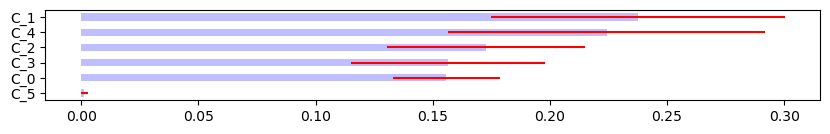

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import multiprocessing as mp

from finance_ml.importance import feat_imp_MDA_clustered


clf = DecisionTreeClassifier(criterion="entropy", max_features=1, class_weight="balanced", min_weight_fraction_leaf=0)
clf = BaggingClassifier(base_estimator=clf, n_estimators=1000, max_features=1.,
                        max_samples=1., oob_score=False, n_jobs=mp.cpu_count())
imp = feat_imp_MDA_clustered(clf, X, y, clstrs, n_splits=10)
print(imp.head())
imp.sort_values('mean', inplace=True)
plt.figure(figsize=(10, imp.shape[0] / 5))
imp['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=imp['std'], error_kw={'ecolor': 'r'})

As you see in the result above, the cluster containing noise gains low importance.